In [1]:
import json
from utils.constants import LOGOS_TASKS, MODELS,LOGOS, DATASET_SIZES, ALL_SIN_TASKS, ALL_LOGOS_TASKS, ALL_ICONS_TASKS, DOMAINS, LOGOS, SIN, ICONS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib as mpl

In [13]:
import json
from pathlib import Path

# Constants or configuration dictionaries
ALL_TASKS = {"logos": ALL_LOGOS_TASKS, "sin": ALL_SIN_TASKS, "icons": ALL_ICONS_TASKS}

DATASETS = {"logos", "sin", "icons"}
CONTEXT_CRITERIA_OPTIONS = {"icon", "logo", "object"}


def get_tasks(dataset):
    try:
        return ALL_TASKS[dataset]
    except KeyError:
        raise ValueError(f"Dataset '{dataset}' not recognised.")


# Function to determine prediction task and context criteria
def determine_task_criteria(parts_of_task):
    if len(parts_of_task) == 2:
        pred_task = "shape"
        context_criteria = (
            "shape"
            if parts_of_task[1] in CONTEXT_CRITERIA_OPTIONS
            else parts_of_task[1]
        )
    else:
        context_criteria = (
            "shape"
            if parts_of_task[2] in CONTEXT_CRITERIA_OPTIONS
            else parts_of_task[2]
        )
        pred_task = "texture" if parts_of_task[1] == "background" else "both"
    return pred_task, context_criteria


# Initialize data dictionary
data_dict = {}

# Load tasks based on dataset
dataset = "sin"  # Example dataset
tasks = get_tasks(dataset)

# Random baselines.

if dataset == "logos":
    num_shapes = len(LOGOS)  # replace with actual number of shapes
    num_textures = len(DOMAINS)  # replace with actual number of textures
elif dataset == "sin":
    num_shapes = len(SIN)  # replace with actual number of shapes
    num_textures = len(DOMAINS)  # replace with actual number of textures
elif dataset == "icons":
    num_shapes = len(ICONS)  # replace with actual number of shapes
    num_textures = len(DOMAINS)  # replace with actual number of textures
    # NOTE: Appanreltyy use few domains for messages.
else:
    raise ValueError(f"Dataset '{dataset}' not recognised.")

# Calculate random baselines
random_shape_baseline = 1 / num_shapes
random_texture_baseline = 1 / num_textures

# Loop over tasks to load data
for task in tasks:
    task_path = Path(f"results/{task}/results.json")
    if not task_path.is_file():
        continue

    with task_path.open() as f:
        data = json.load(f)
        for model in MODELS:
            model_data = data.get(model, {})
            parts_of_task = task.split("_")
            pred_task, context_criteria = determine_task_criteria(parts_of_task)

            if pred_task not in data_dict:
                data_dict[pred_task] = {}
            if context_criteria not in data_dict[pred_task]:
                data_dict[pred_task][context_criteria] = {}
            if model not in data_dict[pred_task][context_criteria]:
                data_dict[pred_task][context_criteria][model] = {}

            for shot, values in model_data.items():
                if int(shot) not in data_dict[pred_task][context_criteria][model]:
                    data_dict[pred_task][context_criteria][model][int(shot)] = values
                    data_dict[pred_task][context_criteria][model][int(shot)][
                        "texture_accuracy"
                    ] = data_dict[pred_task][context_criteria][model][int(shot)][
                        "background_accuracy"
                    ]
                    # Get rid of background accuracy
                    del data_dict[pred_task][context_criteria][model][int(shot)][
                        "background_accuracy"
                    ]

# Save data dictionary
with open(f"results/icl_{dataset}_plotting_data.json", "w") as f:
    json.dump(data_dict, f, indent=4)


Plotting shape - neither: Shots [0, 1, 2, 4, 8]
idefics-9b-instruct - neither Shape Acc: [17.871017871017873, 17.34265734265734, 17.016317016317018, 18.492618492618494, 21.585081585081586]
idefics-9b-instruct - neither Scene Acc: [35.33799533799534, 29.1996891996892, 30.878010878010876, 32.525252525252526, 26.30924630924631]
llava16-7b - neither Shape Acc: [26.557886557886555, 1.8803418803418803, 0.8857808857808859, 2.470862470862471, 0.06216006216006216]
llava16-7b - neither Scene Acc: [6.853146853146853, 0.10878010878010878, 0.20202020202020202, 2.268842268842269, 0.43512043512043513]
mmicl-t5-xxl - neither Shape Acc: [23.962703962703962, 22.284382284382286, 22.937062937062937, 23.123543123543126, 23.418803418803417]
mmicl-t5-xxl - neither Scene Acc: [62.19114219114219, 66.26262626262627, 68.7024087024087, 69.75912975912976, 66.37140637140637]
otter-mpt - neither Shape Acc: [15.81973581973582, 9.696969696969697, 10.48951048951049, 11.08003108003108, 6.511266511266511]
otter-mpt - nei

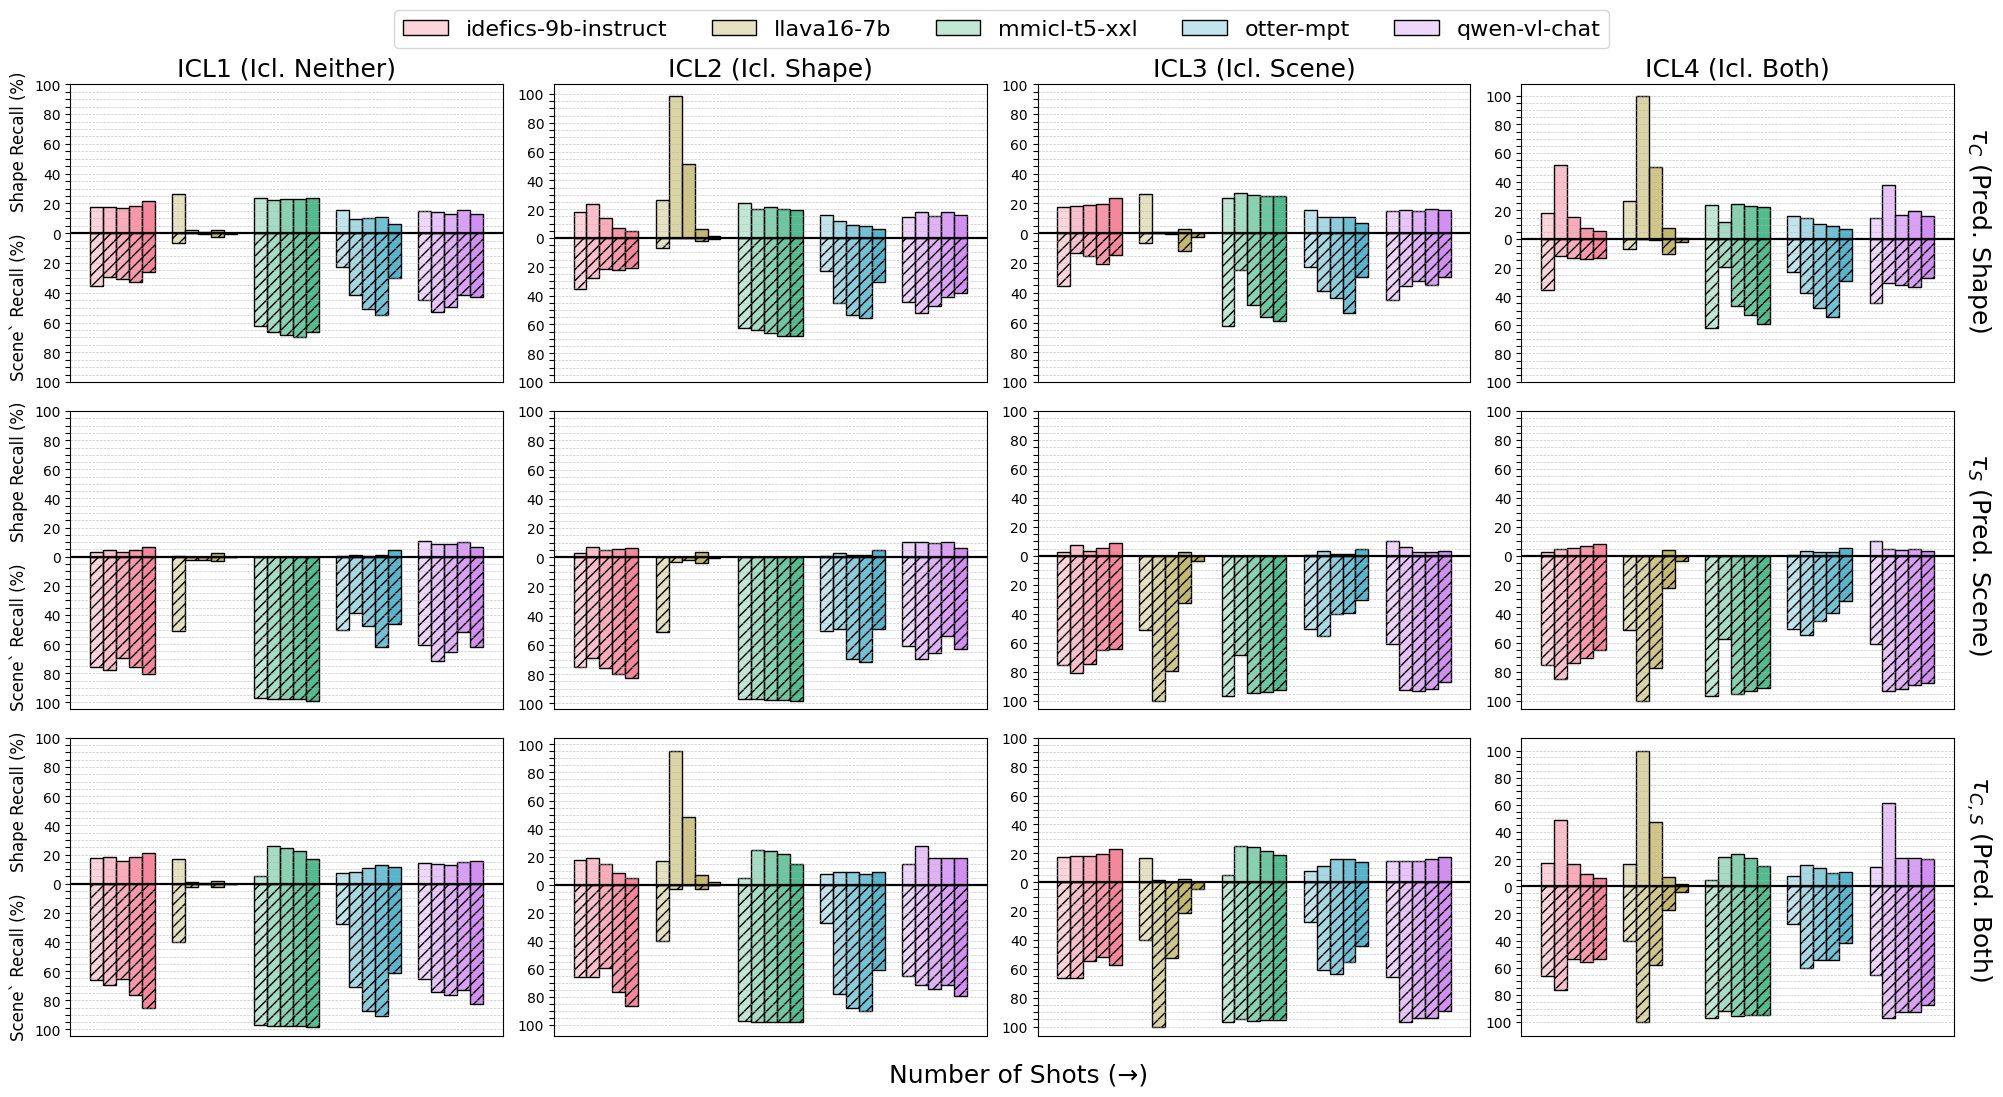

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Ensure LaTeX rendering is disabled
mpl.rcParams['text.usetex'] = False

# Define the contexts, tasks, models, and colors
contexts = ["neither", "shape", "background", "both"]
tasks = ["shape", "texture", "both"]
tasks_map = {"shape": "C", "texture": "S", "both": "C,S"}
models = ["idefics-9b-instruct", "llava16-7b", "mmicl-t5-xxl", "otter-mpt", "qwen-vl-chat"]
context_map = {"neither": "ICL1 (Icl. Neither)", "shape": "ICL2 (Icl. Shape)", "background": "ICL3 (Icl. Scene)", "both": "ICL4 (Icl. Both)"}
colors = sns.color_palette("husl", len(models))

# Create a 3x4 grid for the subplots with shared y-axis
fig, axs = plt.subplots(3, 4, figsize=(20, 11), sharey=False)

# Set up row labels for prediction tasks
for i, task in enumerate(tasks):
    if task == "texture":
        plot_task = "Scene"
    else:
        plot_task = task
    title = r"$\tau_{" + tasks_map[task] + "}$ (Pred. " + plot_task.capitalize() + ")"
    fig.text(0.99, 0.79 - i * 0.295, title, va='center', ha='center', rotation=270, fontsize=18)

    # Add text annotations for y-axis labels
    fig.text(0.01, 0.87 - i * 0.3, 'Shape Recall (%)', va='center', ha='center', rotation='vertical', fontsize=12)
    fig.text(0.01, 0.72 - i * 0.3, 'Scene` Recall (%)', va='center', ha='center', rotation='vertical', fontsize=12)

for i, task in enumerate(tasks):
    for j, context_criteria in enumerate(contexts):
        ax = axs[i, j]

        # Check if the task and context criteria exist in the weighted_averages dictionary
        if task not in data_dict or context_criteria not in data_dict[task]:
            if i == 0:
                ax.set_title(f'{context_map[context_criteria]}')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        valid_models = [model for model in models if model in data_dict[task][context_criteria]]
        if not valid_models:
            if i == 0:
                ax.set_title(f'{context_criteria.capitalize()}')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        shots = sorted(data_dict[task][context_criteria][valid_models[0]].keys())
        if not shots:
            if i == 0:
                ax.set_title(f'{context_criteria.capitalize()}')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        print(f"Plotting {task} - {context_criteria}: Shots {shots}")

        bar_width = 0.15  # Width of each bar
        spacing = bar_width * len(shots) + 0.2  # Space between different model groups, reduced slightly
        x = np.arange(len(models)) * spacing  # X positions for each model group

        for idx, model in enumerate(models):
            if model not in data_dict[task][context_criteria]:
                continue

            model_data = data_dict[task][context_criteria][model]
            shape_acc = [model_data[shot].get("shape_accuracy", 0) * 100 for shot in shots]  # Convert to percentage
            texture_acc = [model_data[shot].get("texture_accuracy", 0) * 100 for shot in shots]  # Convert to percentage

            print(f"{model} - {context_criteria} Shape Acc: {shape_acc}")
            print(f"{model} - {context_criteria} Scene Acc: {texture_acc}")

            # Bar positions for shape and texture accuracies within each model group
            positions = x[idx] + np.arange(len(shots)) * bar_width

            for shot_idx, shot in enumerate(shots):
                alpha_value = 0.3 + 0.7 * (shot_idx / len(shots))  # Make the gradient more pronounced

                # Plot shape accuracy (positive bars)
                ax.bar(positions[shot_idx], shape_acc[shot_idx], bar_width, label=f'{model}' if j == 0 and i == 0 and shot_idx == 0 else "", color=colors[idx] + (alpha_value,), edgecolor='black')
                # Plot texture accuracy (negative bars) with more hatching
                ax.bar(positions[shot_idx], -texture_acc[shot_idx], bar_width, color=colors[idx] + (alpha_value,), edgecolor='black', hatch='///')

        if i == 0:
            ax.set_title(f'{context_map[context_criteria]}', fontsize=18)

        # Set y-ticks and convert to positive values for labels
        y_ticks = np.arange(-100, 105, 5)
        y_tick_labels = [f"{abs(tick):.0f}" if (idx % 4 == 0) else "" for idx, tick in enumerate(y_ticks)]
        print(f"Y-ticks: {y_ticks}")
        print(f"Y-tick labels: {y_tick_labels}")
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_tick_labels)

        # Make the x-axis line bolder
        ax.axhline(0, color='black', linewidth=1.6)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Set x-ticks in the middle of the groups of models
        ax.set_xticks([])
        ax.set_xticklabels([])

# Super x-label
fig.supxlabel('Number of Shots (→)', fontsize=18, y=0.01, x=0.51)

# Add legend with note about color gradient
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles[:len(models)], labels[:len(models)], loc='upper center', ncol=len(models), fontsize=16)


plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Reduce the space between plots

plt.tight_layout(rect=[0.01, 0.005, 0.985, 0.96])  # Adjust the top margin to make space for the legend

# Save as pdf 
plt.savefig(f'results/icl_{dataset}.pdf')
plt.show()


In [7]:
import json
from pathlib import Path

# Constants or configuration dictionaries
ALL_TASKS = {"logos": ALL_LOGOS_TASKS, "sin": ALL_SIN_TASKS, "icons": ALL_ICONS_TASKS}

DATASETS = {"logos", "sin", "icons"}
CONTEXT_CRITERIA_OPTIONS = {"icon", "logo", "object"}

DATASET_SIZES = {
    "icons": 20064,
    "logos": 2860,
    "sin": 6435
}

def get_tasks(dataset):
    try:
        return ALL_TASKS[dataset]
    except KeyError:
        raise ValueError(f"Dataset '{dataset}' not recognized.")

# Function to determine prediction task and context criteria
def determine_task_criteria(parts_of_task):
    if len(parts_of_task) == 2:
        pred_task = "shape"
        context_criteria = (
            "shape"
            if parts_of_task[1] in CONTEXT_CRITERIA_OPTIONS
            else parts_of_task[1]
        )
    else:
        context_criteria = (
            "shape"
            if parts_of_task[2] in CONTEXT_CRITERIA_OPTIONS
            else parts_of_task[2]
        )
        pred_task = "texture" if parts_of_task[1] == "background" else "both"
    return pred_task, context_criteria

# Initialize data dictionary and weighted averages
weighted_averages = {}

# Compute total size of all datasets
total_size_of_all_datasets = sum(DATASET_SIZES.values())

for dataset in DATASETS:
    tasks = get_tasks(dataset)
    dataset_size = DATASET_SIZES[dataset]

    if dataset == "logos":
        num_shapes = len(LOGOS)  # replace with actual number of shapes
        num_textures = len(DOMAINS)  # replace with actual number of textures
    elif dataset == "sin":
        num_shapes = len(SIN)  # replace with actual number of shapes
        num_textures = len(DOMAINS)  # replace with actual number of textures
    elif dataset == "icons":
        num_shapes = len(ICONS)  # replace with actual number of shapes
        num_textures = len(DOMAINS)  # replace with actual number of textures
    else:
        raise ValueError(f"Dataset '{dataset}' not recognized.")
    
    # Loop over tasks to load data
    for task in tasks:
        task_path = Path(f"results/{task}/results.json")
        if not task_path.is_file():
            continue

        with task_path.open() as f:
            data = json.load(f)
            for model in MODELS:
                model_data = data.get(model, {})
                parts_of_task = task.split("_")
                pred_task, context_criteria = determine_task_criteria(parts_of_task)

                if pred_task not in weighted_averages:
                    weighted_averages[pred_task] = {}
                if context_criteria not in weighted_averages[pred_task]:
                    weighted_averages[pred_task][context_criteria] = {}
                if model not in weighted_averages[pred_task][context_criteria]:
                    weighted_averages[pred_task][context_criteria][model] = {}

                for shot, values in model_data.items():
                    if int(shot) > 4:
                        continue
                    if int(shot) not in weighted_averages[pred_task][context_criteria][model]:
                        weighted_averages[pred_task][context_criteria][model][int(shot)] = {"shape_accuracy": 0, "texture_accuracy": 0}

                    weighted_averages[pred_task][context_criteria][model][int(shot)]["shape_accuracy"] += values.get("shape_accuracy", 0) * dataset_size / total_size_of_all_datasets
                    weighted_averages[pred_task][context_criteria][model][int(shot)]["texture_accuracy"] += values.get("background_accuracy", 0) * dataset_size / total_size_of_all_datasets

# Save the loaded scores
with open(f"results/icl_avg_plotting_data.json", "w") as f:
    json.dump(weighted_averages, f, indent=4)




Plotting shape - neither: Shots [0, 1, 2, 4]
idefics-9b-instruct - neither Shape : [13.85265165707279, 18.501992574678976, 20.937361626758406, 24.605742702408122]
idefics-9b-instruct - neither Scene Acc: [40.76433121019109, 36.42494635375865, 34.752546067645355, 40.51568513913962]
llava16-7b - neither Shape : [23.72015395619742, 0.8072482032766783, 0.745938213154399, 0.7970298715896319]
llava16-7b - neither Scene Acc: [9.322524609148813, 0.5722265744746076, 0.4802615892911884, 2.5307401478251985]
mmicl-t5-xxl - neither Shape : [20.409414489594333, 21.54705541741885, 22.868626315610204, 23.38635512108723]
mmicl-t5-xxl - neither Scene Acc: [70.05688204639122, 70.59504751524234, 69.94448039783371, 70.20675091113458]
otter-mpt - neither Shape : [12.020164174529105, 8.43693586293811, 9.819816751251746, 11.243570966313566]
otter-mpt - neither Scene Acc: [28.10722436050274, 40.26363295752581, 47.85585340100139, 53.312442521884265]
qwen-vl-chat - neither Shape : [5.613270206750911, 6.573793385

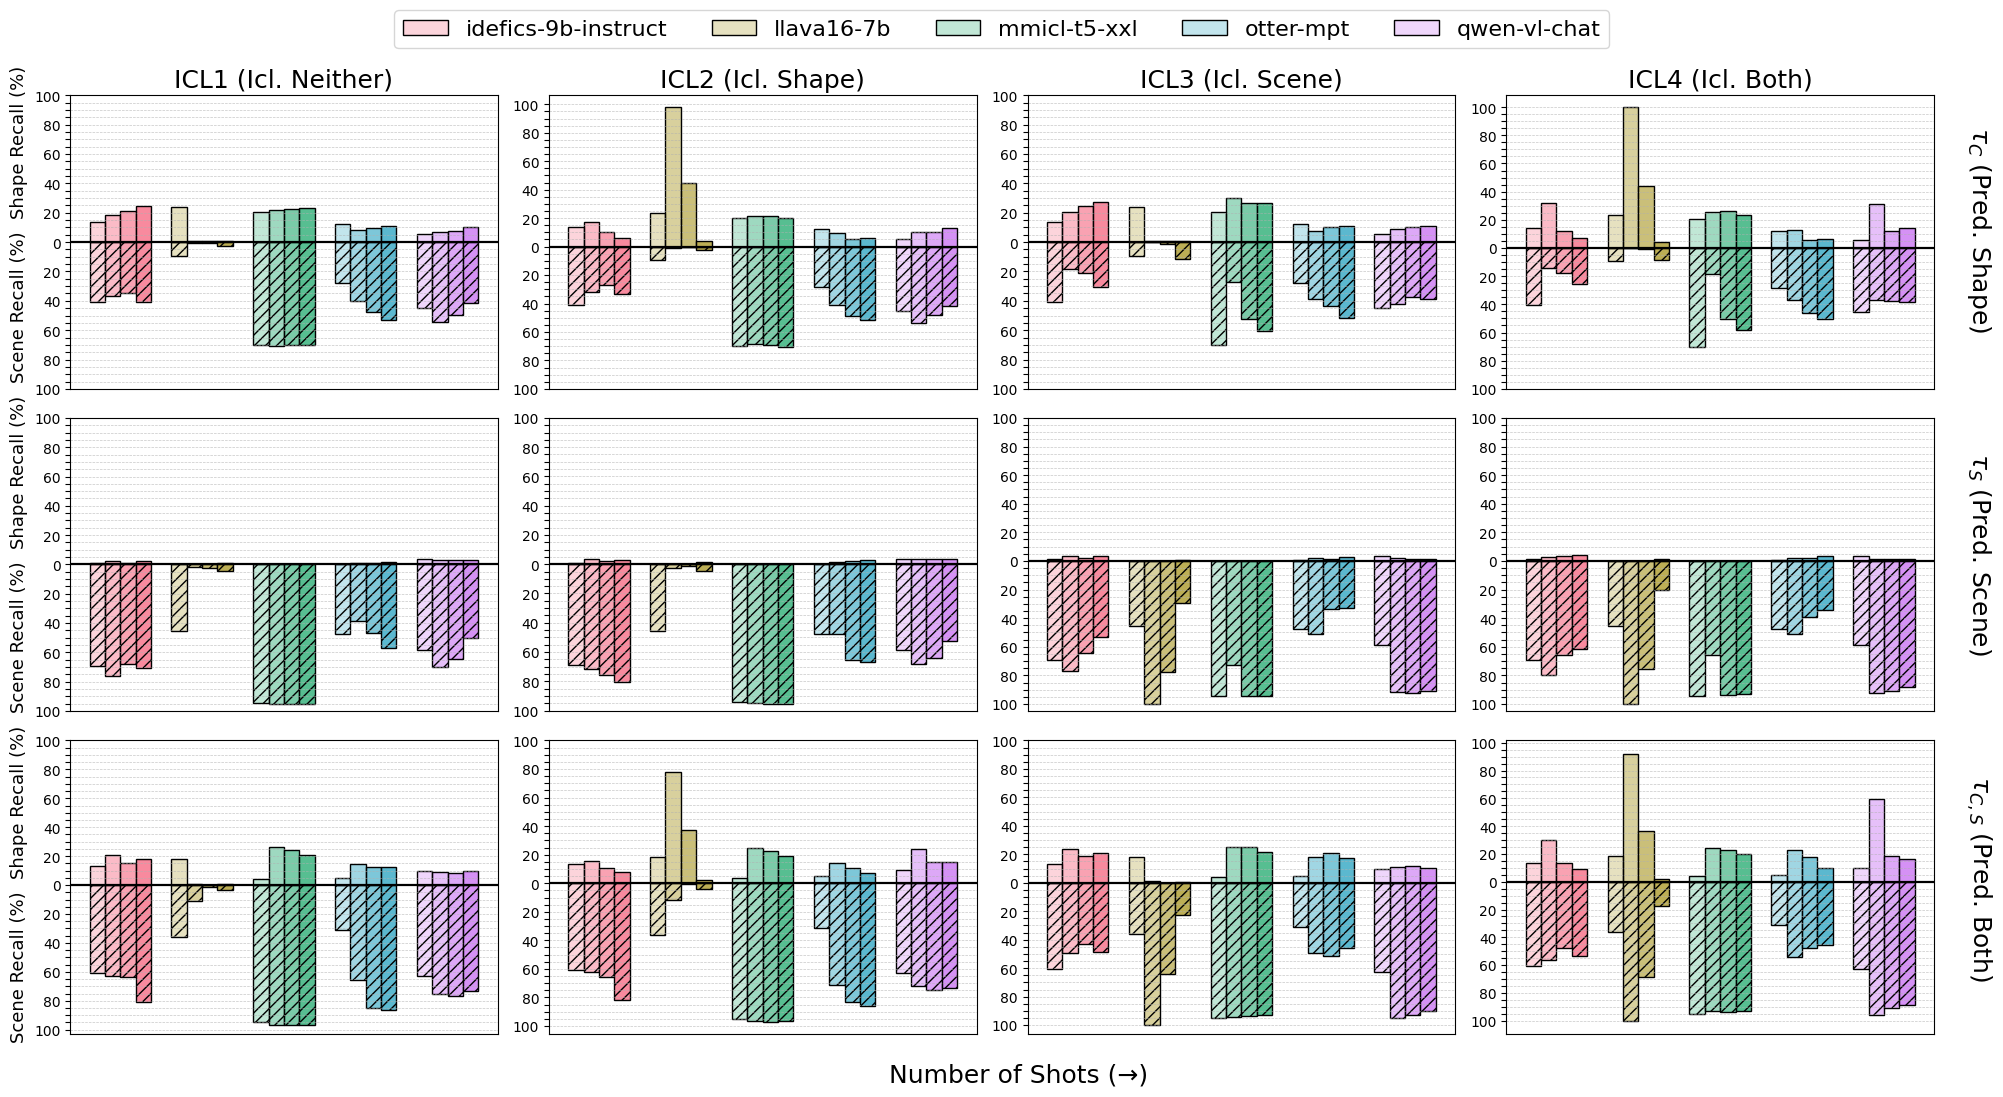

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Ensure LaTeX rendering is disabled
mpl.rcParams['text.usetex'] = False

# Define the contexts, tasks, models, and colors
contexts = ["neither", "shape", "background", "both"]
tasks = ["shape", "texture", "both"]
tasks_map = {"shape": "C", "texture": "S", "both": "C,S"}
models = ["idefics-9b-instruct", "llava16-7b", "mmicl-t5-xxl", "otter-mpt", "qwen-vl-chat"]
context_map = {"neither": "ICL1 (Icl. Neither)", "shape": "ICL2 (Icl. Shape)", "background": "ICL3 (Icl. Scene)", "both": "ICL4 (Icl. Both)"}
colors = sns.color_palette("husl", len(models))

# Create a 3x4 grid for the subplots with shared y-axis
fig, axs = plt.subplots(3, 4, figsize=(20, 11), sharey=False)

# Set up row labels for prediction tasks
for i, task in enumerate(tasks):
    if task == "texture":
        plot_task = "Scene"
    else:
        plot_task = task
    title = r"$\tau_{" + tasks_map[task] + "}$ (Pred. " + plot_task.capitalize() + ")"
    fig.text(0.99, 0.79 - i * 0.295, title, va='center', ha='center', rotation=270, fontsize=18)

    # Add text annotations for y-axis labels
    fig.text(0.01, 0.87 - i * 0.3, 'Shape Recall (%)', va='center', ha='center', rotation='vertical', fontsize=13)
    fig.text(0.01, 0.72 - i * 0.3, 'Scene Recall (%)', va='center', ha='center', rotation='vertical', fontsize=13)

for i, task in enumerate(tasks):
    for j, context_criteria in enumerate(contexts):
        ax = axs[i, j]

        # Check if the task and context criteria exist in the weighted_averages dictionary
        if task not in weighted_averages or context_criteria not in weighted_averages[task]:
            if i == 0:
                ax.set_title(f'{context_map[context_criteria]}')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        valid_models = [model for model in models if model in weighted_averages[task][context_criteria]]
        if not valid_models:
            if i == 0:
                ax.set_title(f'{context_criteria.capitalize()}')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        shots = sorted(weighted_averages[task][context_criteria][valid_models[0]].keys())
        if not shots:
            if i == 0:
                ax.set_title(f'{context_criteria.capitalize()}')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        print(f"Plotting {task} - {context_criteria}: Shots {shots}")

        bar_width = 0.15  # Width of each bar
        spacing = bar_width * len(shots) + 0.2  # Space between different model groups, reduced slightly
        x = np.arange(len(models)) * spacing  # X positions for each model group

        for idx, model in enumerate(models):
            if model not in weighted_averages[task][context_criteria]:
                continue

            model_data = weighted_averages[task][context_criteria][model]
            shape_acc = [model_data[shot].get("shape_accuracy", 0) * 100 for shot in shots]  # Convert to percentage
            texture_acc = [model_data[shot].get("texture_accuracy", 0) * 100 for shot in shots]  # Convert to percentage

            print(f"{model} - {context_criteria} Shape : {shape_acc}")
            print(f"{model} - {context_criteria} Scene Acc: {texture_acc}")

            # Bar positions for shape and texture accuracies within each model group
            positions = x[idx] + np.arange(len(shots)) * bar_width

            for shot_idx, shot in enumerate(shots):
                alpha_value = 0.3 + 0.7 * (shot_idx / len(shots))  # Make the gradient more pronounced

                # Plot shape accuracy (positive bars)
                ax.bar(positions[shot_idx], shape_acc[shot_idx], bar_width, label=f'{model}' if j == 0 and i == 0 and shot_idx == 0 else "", color=colors[idx] + (alpha_value,), edgecolor='black')
                # Plot texture accuracy (negative bars) with more hatching
                ax.bar(positions[shot_idx], -texture_acc[shot_idx], bar_width, color=colors[idx] + (alpha_value,), edgecolor='black', hatch='///')

        if i == 0:
            ax.set_title(f'{context_map[context_criteria]}', fontsize=18)

        # Set y-ticks and convert to positive values for labels
        y_ticks = np.arange(-100, 105, 5)
        y_tick_labels = [f"{abs(tick):.0f}" if (idx % 4 == 0) else "" for idx, tick in enumerate(y_ticks)]
        print(f"Y-ticks: {y_ticks}")
        print(f"Y-tick labels: {y_tick_labels}")
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_tick_labels)

        # Make the x-axis line bolder
        ax.axhline(0, color='black', linewidth=1.6)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Set x-ticks in the middle of the groups of models
        ax.set_xticks([])
        ax.set_xticklabels([])

# Super x-label
fig.supxlabel('Number of Shots (→)', fontsize=18, y=0.01, x=0.51)

# Add legend with note about color gradient
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles[:len(models)], labels[:len(models)], loc='upper center', ncol=len(models), fontsize=16)


plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Reduce the space between plots

plt.tight_layout(rect=[0.01, 0.005, 0.975, 0.95])  # Adjust the top margin to make space for the legend

# Save as pdf 
plt.savefig('results/icl_averaged_results.pdf')
plt.show()


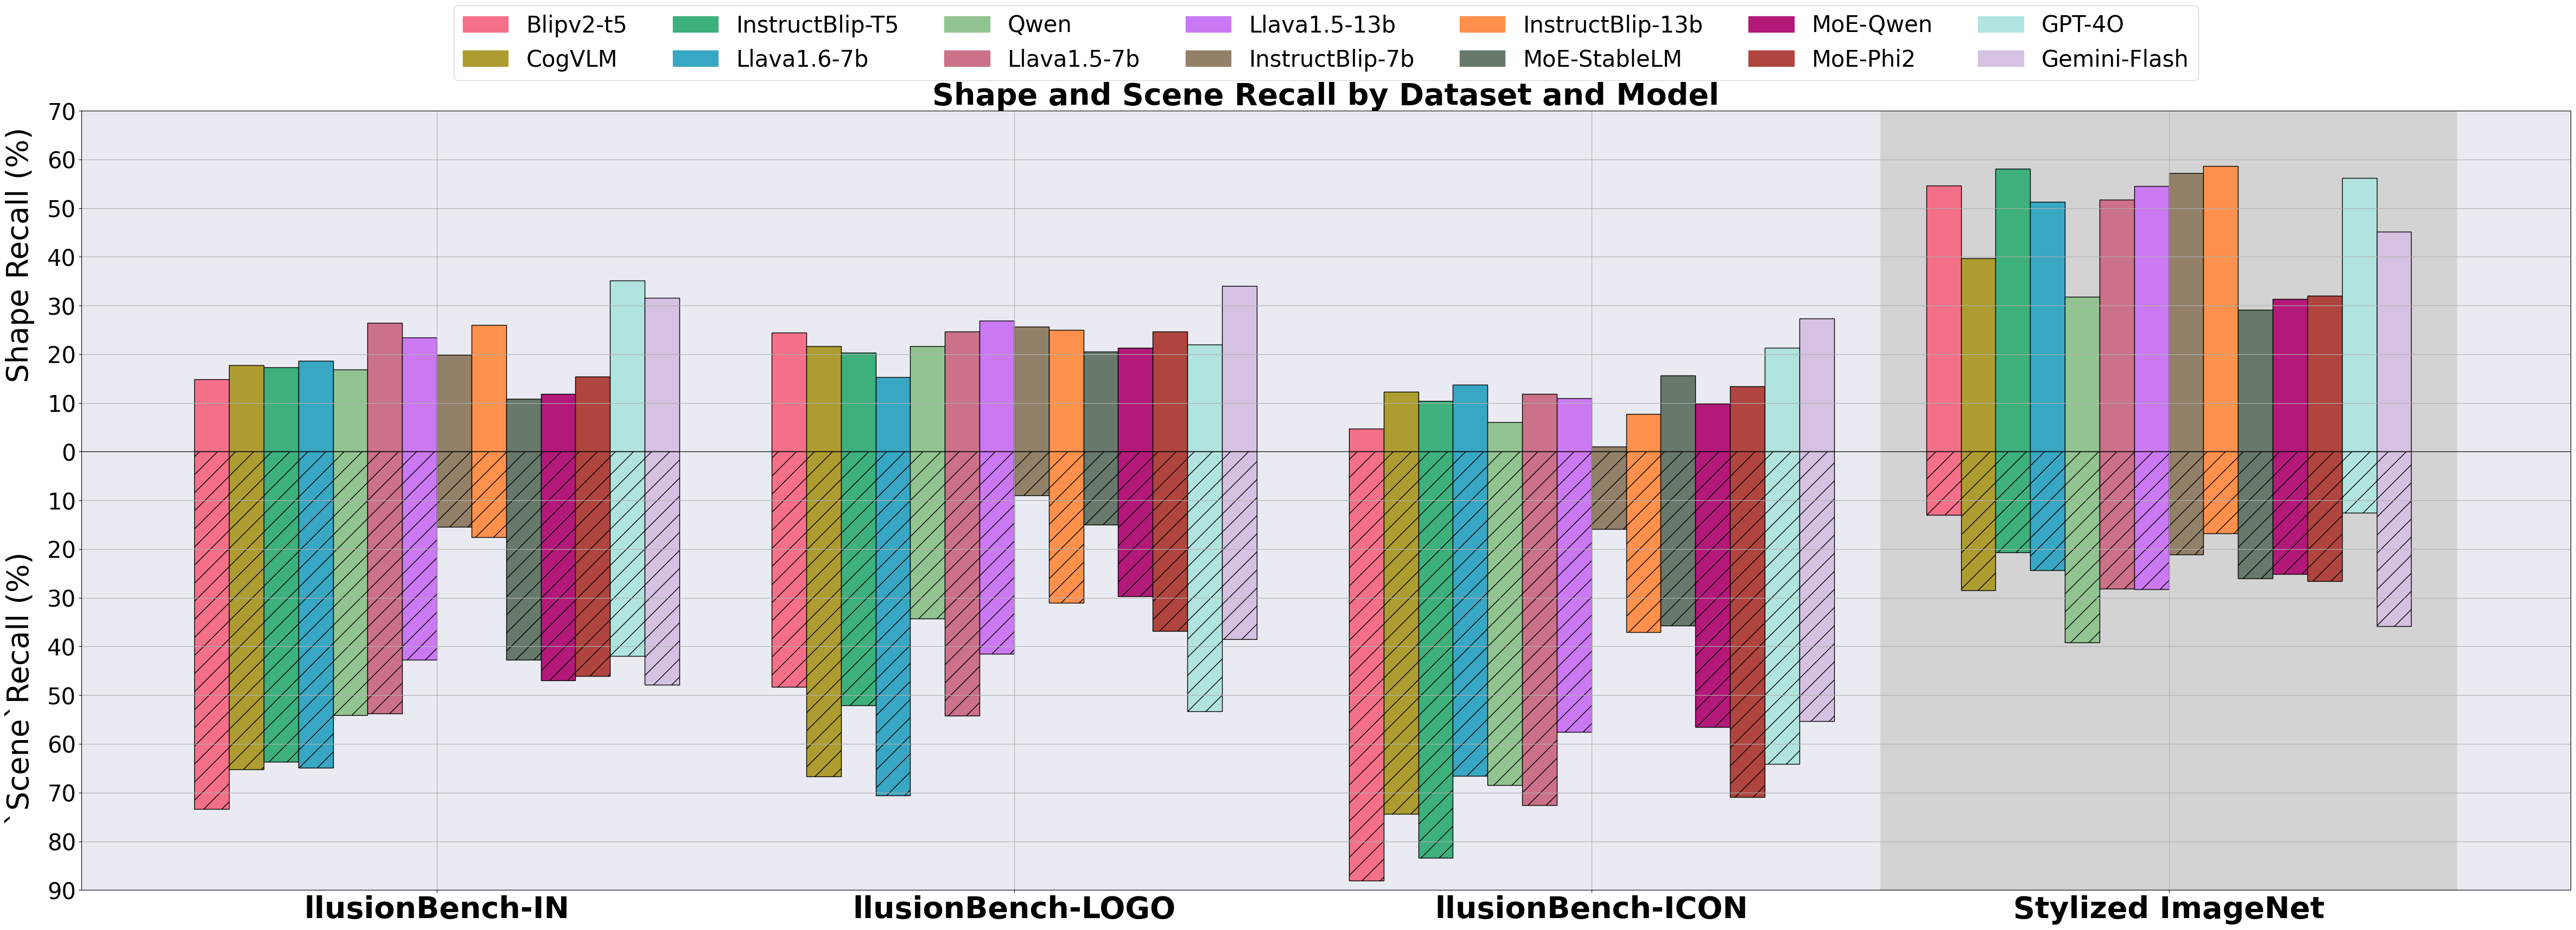

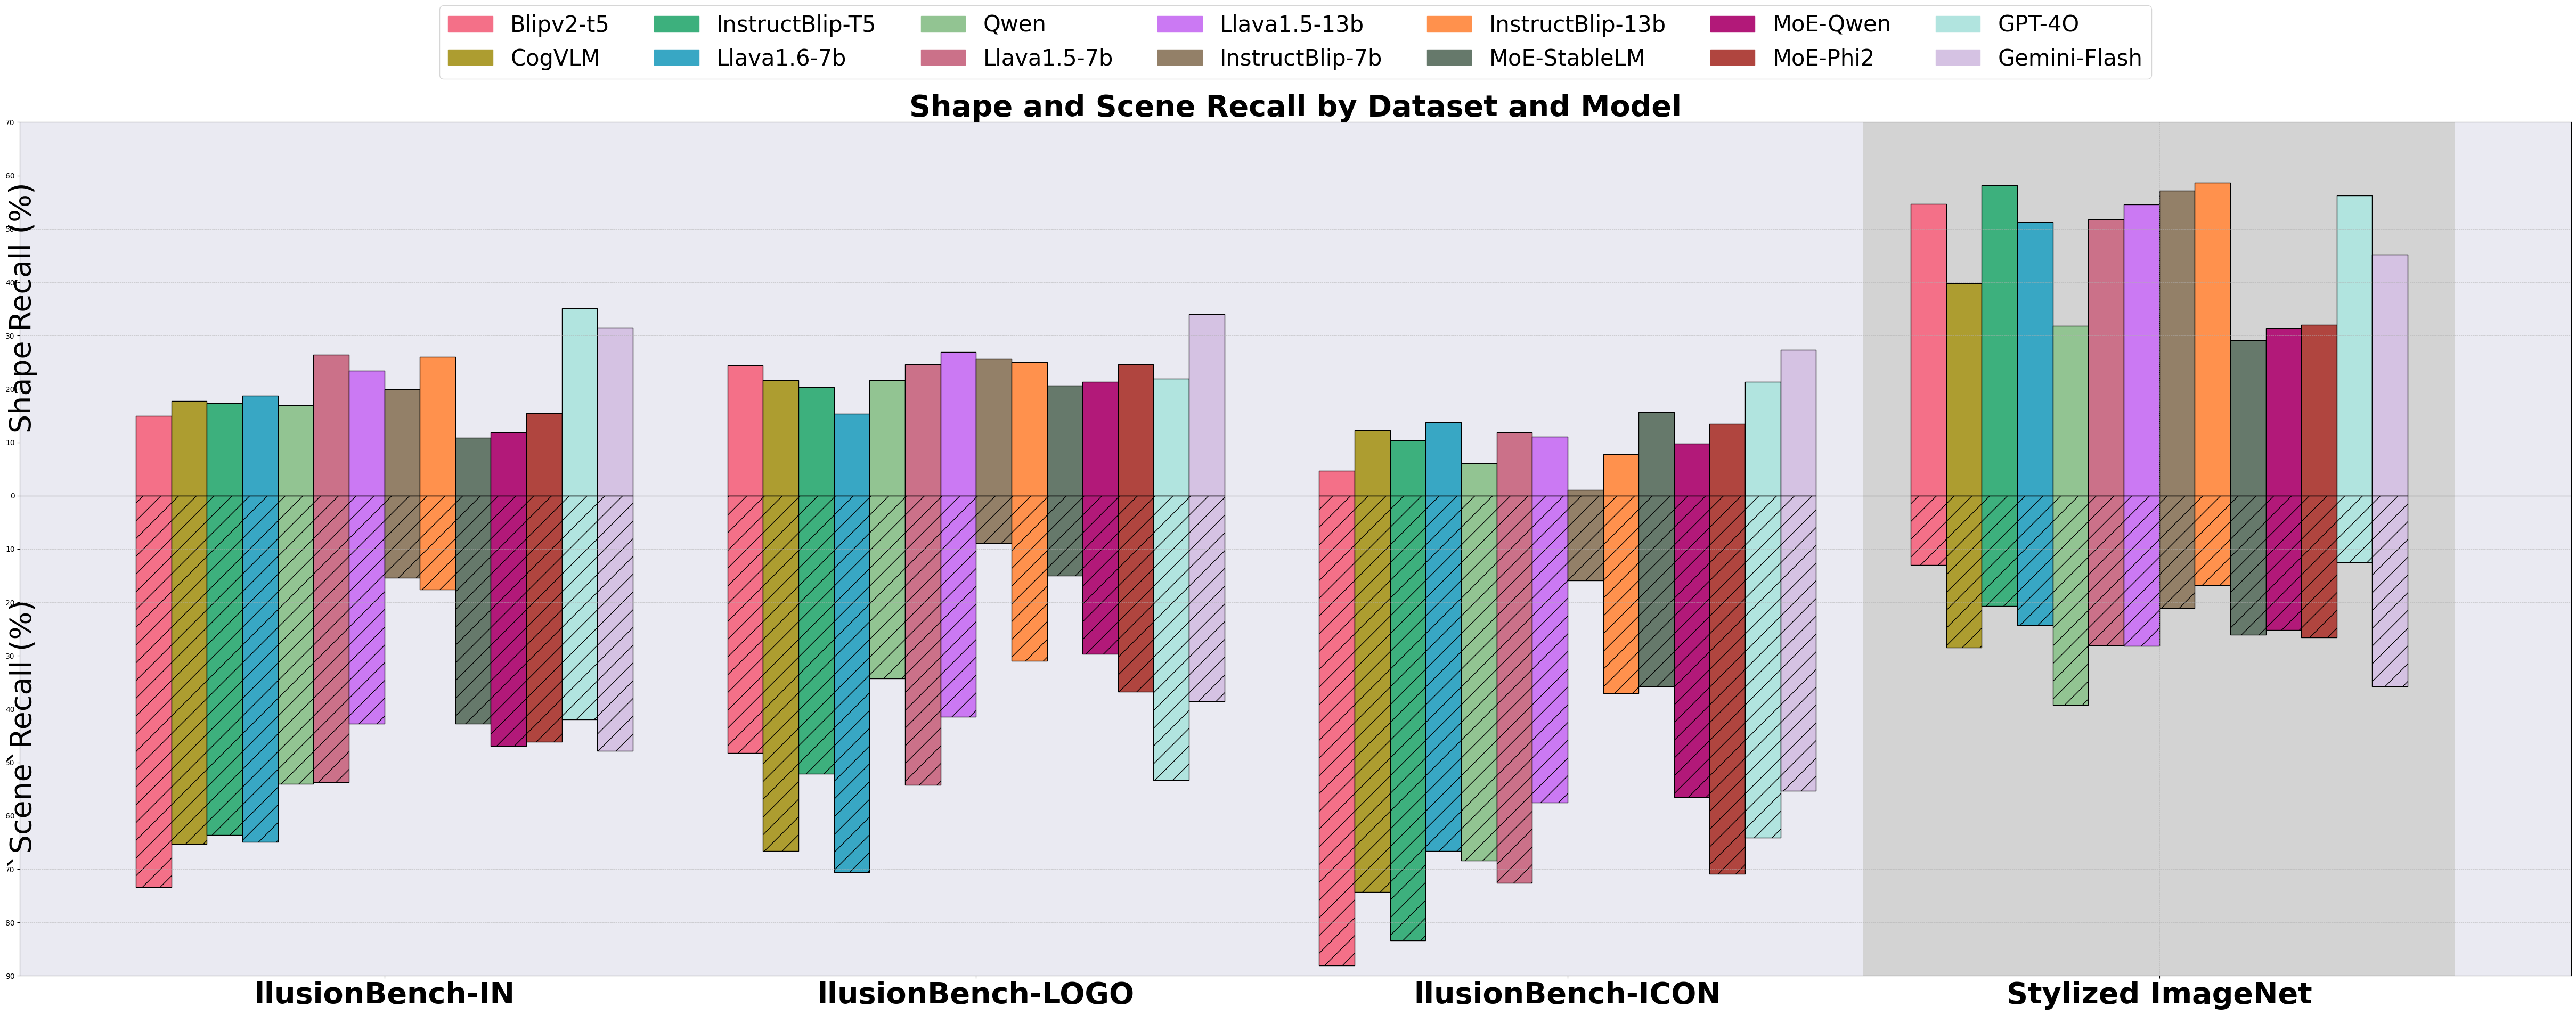